<a href="https://www.kaggle.com/code/argyrisanastopoulos/house-price-prediction-from-listings-greece?scriptVersionId=117615189" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

The aim of this kernel is to develop a DeepLearning model that predicts the price of a property. House listings are used as input data. Using listings may not be the most accurate source of truth, but it has certain benefits: A seller (or a buyer) wants to know the advertised price for a given property, even if he is willing to go higher/lower for the actual purchase. The other advantage is that this kind of data is publicly available and there is a great variety of houses for many different locations. Listings often change prices, so data needs to be updated regularly and make sure that the latest price is always presented. Listings that are removed are also depicted in the data - a removal though does not necessarily mean that the property has been sold, it may be that the listing has just expired.

The listings are for the 2 areas in Greece with the greatest density of population, which is Attika and Thessaloniki. Expanding the coverage in other areas is of doubtful value, given rural areas are more sparse and prone to outliers.

The categorical features are in Greek, so sorry about that! I'm including the translated values when possible and a description for each feature.

The dataset attached to this kernel has 20.000 entries and it is indicative. I'm including the R2 score for the full dataset and how the score improves when more data is used. 


# Data Preparation

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime

# Read raw data from the CSV
data = pd.read_csv('../input/greece-property-listings/greece_listings.csv')

# Convert the publication date of the listing to a number (Listing Age)
# Listing Age shows how old is the listing, measured in days
# today: listing_age = 0, yesterday: listing_age =-1 and so on
now = datetime.now()
data['res_date'] = pd.to_datetime(data['res_date'])
data['listing_age'] = data['res_date'].apply(lambda date:round((date-now)/np.timedelta64(1,'D'),0))

# creating 2 new features, one for the month and one for the year of the publication date
data['month'] = data['res_date'].apply(lambda date:date.month)
data['year'] = data['res_date'].apply(lambda date:date.year)

# Dropping some features. 
data = data.drop(['deleted_at', 'res_date','res_price_sqr'], axis = 1)


## Handling categorical features

I researched the different methods used to handle the categorical features. As widely known, there are 3 factors that determine the value of a house, and these are "Location, Location, Location". I was surprised to see that many house pricing models in Kaggle do not seem to take this into consideration.

[this](https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark) is a useful article to get an overview of the different categorical encoders.

Using an encoder like MEstimateEncoder or TargetEncoder needs to be done with caution, given it uses the whole training set and in this way, it by-passes the "learning process". I used them for the main location attributes and I noticed significant improvement (especially with the Random Forest Regressor).

I did various experiments for the remaining categorical features. It turns out that using a combination of Ordinal and One Hot encoder gives the best results. Using one hot encoding ends up in too many features, with most of them not being used. Nevertheless, the regressors are doing a good job to figure out the importance of each feature and utilize it accordingly!It is a fair alternative to having to do this assessment and fine-tuning by other means.

In [2]:
from category_encoders.m_estimate import MEstimateEncoder,OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

# Replace location and address features with their M-probability against the residence price. 
encoder = MEstimateEncoder()
e_features = ['location_name','res_address']
data[e_features] = encoder.fit_transform(round(data[e_features],0), data['res_price'])

# Ordinal encoding 
o_features = ['levels','parking']
encoder = OrdinalEncoder(o_features)
data[o_features] = encoder.fit_transform(data[o_features])

# Hot key encoding 
h_features = ['location_region','res_type','energyclass','status']
encoder = OneHotEncoder(h_features)
data =  encoder.fit_transform(data)

## Remove outliers and normalize

This step is really important for improving the R2 score. I initially tried to remove outliers across all features (by using stats from scipy and the zscore). This ended up removing approximately 25% of the data. This was very aggressive, so my next approach was to remove outliers only for the most significant features. I'm removing entries where the price or the square meters are out of the ordinary. I am using the 98% quantile.

I investigated how I should handle the skewness of the Price. I tried the approach mentioned [here](https://www.kaggle.com/code/vjgupta/reach-top-10-with-simple-model-on-housing-prices). By doing a simple np.log1p, it turns out indeed that the score improves (from 0.82 to 0.87). But when I checked the metrics with the actual/predicted values being inverted (np.expm1), it turns out that the R2 score and the absolute error were not improved at all. In that sense, I'm going to skip for now the skewing.


In [3]:
# for the null values, use the mean
data = data.fillna(data.mean())

# remove outliers
for col in ["res_price","res_sqr"]:
    num =  data.shape[0]
    q_low = data[col].quantile(0.02)
    q_hi  = data[col].quantile(0.98)
    data = data[(data[col] < q_hi) & (data[col] > q_low)]
    filteredNum = data.shape[0]
    print("Removing outliers for feature {}. Removed {} entries".format(col,num-filteredNum)) 

Removing outliers for feature res_price. Removed 858 entries
Removing outliers for feature res_sqr. Removed 783 entries


## Correlations

Let's see what are the features that are highly correlated with Price (res_price). It turns out that **Square meters**, **address**, **bathrooms**, **bedrooms** and **location** are the top ones!

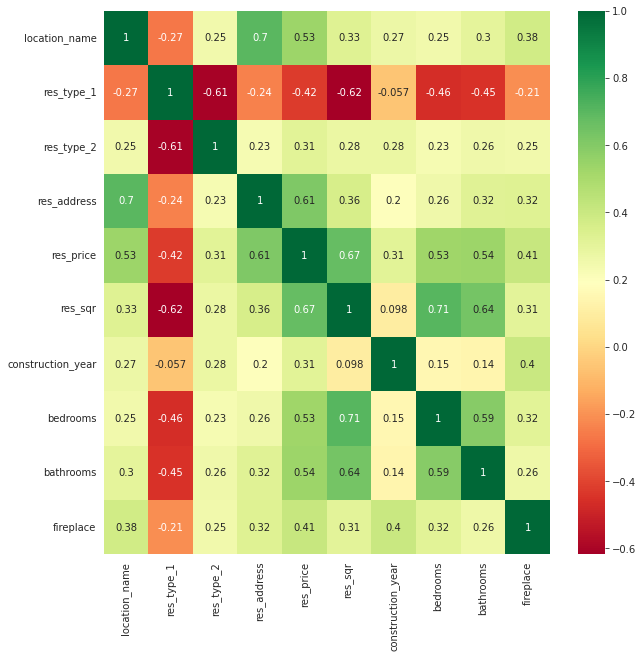

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

corrmat = data.corr()
top_corr_features = corrmat.index[abs(corrmat["res_price"])>0.3]
plt.figure(figsize=(10,10))
g = sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Data split

Doing a standard split. Scaling the data with the sklearn StandardScaler

In [5]:
# let's see the data info
data.info()

# split x,y
y = data['res_price'].values
data = data.drop(['res_price'], axis = 1)
x = data.values
feature_list  = list(data.columns)

# split into training/test data. Scale only the X part of the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x.astype(float))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

# I don't need data,x,y any more. Removing them to free up memory
import gc
del [data,x,y]
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18359 entries, 0 to 19999
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   location_name      18359 non-null  float64
 1   location_region_1  18359 non-null  int64  
 2   location_region_2  18359 non-null  int64  
 3   res_type_1         18359 non-null  int64  
 4   res_type_2         18359 non-null  int64  
 5   res_type_3         18359 non-null  int64  
 6   res_type_4         18359 non-null  int64  
 7   res_type_5         18359 non-null  int64  
 8   res_address        18359 non-null  float64
 9   res_price          18359 non-null  int64  
 10  res_sqr            18359 non-null  float64
 11  construction_year  18359 non-null  float64
 12  levels             18359 non-null  int64  
 13  bedrooms           18359 non-null  float64
 14  bathrooms          18359 non-null  float64
 15  deleted            18359 non-null  int64  
 16  status_1           183

0

# Model 

I started with LinearRegression and the common linear models (Ridge, Lasso, ElasticNet). None of them could exceed a score of 68%, so I decided to not use them at all.

I also tried a sequential model, trying to fine-tune the number of the hidden layers and improve accuracy. The maximum score I got was 70%, so again this is inferior to the gradient boosting and random forest regressors.

I'm using **RandomForestRegressor**, **LGBMRegressor** and **XGBRegressor** which exceeds the 80% accuracy on the test data, even in the small dataset included here. I'm combining the models in a **StackingCVRegressor** in order to get an improved accuracy and make better use of the diversity coming from different models.


In [6]:
# importing the regressors and the metrics
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# set this to 1 in order to get back the feature importances from the model
verbose = -1

# You provide the actual dataset and the prediction.
# It reports the Mean absolute error and the R2 score
def reportMetrics(caller,actual,prediction):  
    print(caller + " MAE {}".format(metrics.mean_absolute_error(actual, prediction))) 
    score = metrics.explained_variance_score(actual,prediction)   
    print(caller +  " VarScore {}".format(score))  
    return score

# It fits the model and reports the training and the testing scores
# If verbose>0, then you can also see the features order by importance
def fitAndReport(model,x_train,y_train,x_test,y_test):
    modelType = type(model).__name__
    
    model.fit(X=x_train,y=y_train)

    y_train_pred = model.predict(x_train)
    reportMetrics("{} - Train".format(modelType),y_train,y_train_pred)

    y_test_pred = model.predict(x_test)
    score = reportMetrics("{} - Test".format(modelType),y_test,y_test_pred)  

    if  verbose > 0 and hasattr(model, 'feature_importances_'):
        # Get numerical feature importances
        importances = list(model.feature_importances_)
        # List of tuples with variable and importance
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        # Sort the feature importances by most important first
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        # Print out the feature and importances 
        [print(modelType + ' Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

    return score


## Regressors

In [7]:
# Random Forest
rForest = RandomForestRegressor(bootstrap=False, max_depth=80, max_features='sqrt',n_estimators=300 )
fitAndReport(rForest,x_train,y_train,x_test,y_test)

# LightGBM regressor (gradient boosting)
lgbm = LGBMRegressor(bagging_freq=0, learning_rate=0.05, n_estimators=300,num_leaves=186, objective='regression', subsample=0.2)
fitAndReport(lgbm,x_train,y_train,x_test,y_test)

# Extreme Gradient Boosting (XGBoost) 
xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=0.8,
                learning_rate=0.2, max_depth=6, min_child_weight=1, 
                n_estimators=300, predictor='auto', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, subsample=1,
                validate_parameters=1, verbosity=1) 
fitAndReport(xgb_model,x_train,y_train,x_test,y_test)

# Combine the above models
stack_gen = StackingCVRegressor(regressors = (lgbm,xgb_model,rForest),
                                meta_regressor=rForest,
                                cv = 3,
                                verbose = 2,
                                n_jobs = 1,
                                pre_dispatch = 1,
                                use_features_in_secondary=True)
score = fitAndReport(stack_gen,x_train, y_train, x_test,y_test)

print("-----------------------------") 
#print("Final Score {}".format(score)) 
print("-----------------------------") 

RandomForestRegressor - Train MAE 30.256988574848386
RandomForestRegressor - Train VarScore 0.9999987320508841
RandomForestRegressor - Test MAE 63642.31527475188
RandomForestRegressor - Test VarScore 0.815547662409465
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
LGBMRegressor - Train MAE 26214.627796834444
LGBMRegressor - Train VarScore 0.9782342053731378
LGBMRegressor - Test MAE 61230.86047232911
LGBMRegressor - Test VarScore 0.8265266680238139
XGBRegressor - Train MAE 28965.987288434113
XGBRegressor - Train VarScore 0.9751646944389957
XGBRegressor - Test MAE 61971.77988196146
XGBRegressor - Test VarScore 0.8222164260611691
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.3s finished


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
StackingCVRegressor - Train MAE 17924.710687593724
StackingCVRegressor - Train VarScore 0.9846537567239496
StackingCVRegressor - Test MAE 58491.22811607359
StackingCVRegressor - Test VarScore 0.8351422743803346
-----------------------------
-----------------------------


# Model Tuning

Given the different data manipulations and the various regressors being used, I wanted an easy approach for tuning the parameters. I ended up using the below code, which gave me a consistent and straightforward way to fine-tune and get the optimal parameters.

In [8]:
from sklearn.model_selection import RandomizedSearchCV

def modelTuning(regressor,x_train, y_train):    
    regressorType = type(regressor).__name__
    print('Starting random grid search for regressor {}'.format(regressorType))
    if regressorType == 'LGBMRegressor':
        parameters = {
            'learning_rate': [0.1,0.05,0.3],
            'num_leaves': [93,186,620],
            'boosting_type' : ['gbdt'],
            'objective' : ['regression'],
            'max_depth' : [-1],           
            'bagging_freq' :[0,1],
            'subsample' : [0.2,0.6,1],          
            'n_estimators': [300]
        }
    if regressorType == 'XGBRegressor':
        parameters = {
              'objective':['reg:squarederror','reg:squaredlogerror'],           
              'learning_rate': [0.3,0.1,0.05,0.2],
              'max_depth': [None],
              'min_child_weight': [None,1,100],
              'subsample': [None,0.5,1],
              'colsample_bytree': [0.2,0.8,1],
              'n_estimators': [300],
              'tree_method' : ['hist','auto']
            }
    if regressorType == 'RandomForestRegressor':
        parameters = {
            'n_estimators': [300],
            'criterion': ['mse'],
            'max_features': ['sqrt','auto','log2'],
            'max_depth': [10,40,80,None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [False]
        }
    grid = RandomizedSearchCV(estimator = regressor, param_distributions = parameters, n_iter = 350, cv = 5, verbose=2, n_jobs = -1, pre_dispatch = 2)    
    grid.fit(x_train, y_train)
    print(grid.best_params_)
    print(grid.best_score_)
    print(grid.best_estimator_)
    return grid.best_estimator_   

#
# commenting out the tuning part, this takes a lot of time!
#

#lgbm = modelTuning(LGBMRegressor(),x_train,y_train)
#fitAndReport(lgbm,x_train, y_train, x_test, y_test)

#rForest = modelTuning(RandomForestRegressor(),x_train,y_train)
#fitAndReport(rForest,x_train, y_train, x_test, y_test)

#xgb = modelTuning(XGBRegressor(),x_train,y_train)
#fitAndReport(xgb,x_train, y_train, x_test, y_test)

# Conclusion

I started collecting this data 3 months ago. The dataset attached here is a subset of random 20.000 rows from the full dataset. As I feed more data to the above model, I see improved accuracy. This is shown in the below diagram. As my data mature, I'd like to see what are the best possible results.

I see listings changing prices every day, and properties can easily go up (or down) several thousands of euros. In that sense, aiming for the "correct" price does not really make much sense. My main focus is the mean absolute error and predicting a reasonable price range that is aligned with the human intuition of the problem.  

I hope you enjoyed this work, I'm waiting for your feedback! 

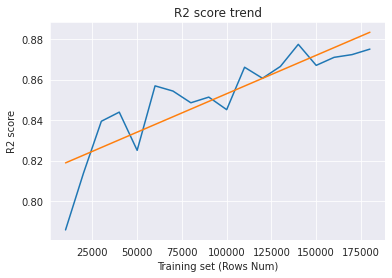

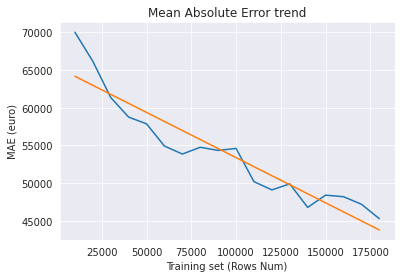

In [9]:
import matplotlib.pyplot as plt

def printWithTrendLine(x,y):
    plt.plot(x,y)
    z = np.polyfit(x,y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x))
    plt.show()

# R2 score graph
scores = [(10000, 0.7857982808743154), (20000, 0.8137682596469334), (30000, 0.8394307132288586), (40000, 0.8439353065477679), (50000, 0.8250686108709222), (60000, 0.8568968990457798), (70000, 0.8543374502470242), (80000, 0.8485508541230603), (90000, 0.8513476815460986), (100000, 0.8451575250140253), (110000, 0.8660876900428442), (120000, 0.8606444916618462), (130000, 0.8664814591914541), (140000, 0.8773914102619654), (150000, 0.8670121898837156), (160000, 0.8709759495356861), (170000, 0.8723223331477851), (180000, 0.8750352842637455)]
x = [x[0] for x in scores]
y = [x[1] for x in scores]
plt.title('R2 score trend')
plt.xlabel('Training set (Rows Num)')
plt.ylabel('R2 score')
printWithTrendLine(x,y)

#Absolute error graph
errors = [(10000, 70028), (20000, 66171), (30000, 61360), (40000, 58758), (50000, 57862), (60000,54915), (70000, 53852), (80000, 54753), (90000, 54333), (100000, 54599), (110000, 50186), (120000, 49091), (130000, 49892), (140000, 46769), (150000, 48391), (160000, 48188), (170000, 47191), (180000, 45272)]
x = [x[0] for x in errors]
y = [x[1] for x in errors]
plt.title('Mean Absolute Error trend')
plt.xlabel('Training set (Rows Num)')
plt.ylabel('MAE (euro)')
printWithTrendLine(x,y)